In [1]:


import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [2]:
datafile = '/content/drive/MyDrive/7151CEM Computing individual project/mental health comments.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['If Yes or No, please explain why']


In [3]:
raw_data.head()

,unique response number,"If Yes or No, please explain why"
0,766562-766553-80584303,NaN
1,766562-766553-80600271,How people look at you and judge you. Tears yo...
2,766562-766553-80608119,Is highly correlated because of the stress and...
3,766562-766553-80609233,May result in low self-esteem/ confidence
4,766562-766553-80609297,You will feel worthless


In [4]:
raw_data.head(10)

,unique response number,"If Yes or No, please explain why"
0,766562-766553-80584303,NaN
1,766562-766553-80600271,How people look at you and judge you. Tears yo...
2,766562-766553-80608119,Is highly correlated because of the stress and...
3,766562-766553-80609233,May result in low self-esteem/ confidence
4,766562-766553-80609297,You will feel worthless
5,766562-766553-80609490,When they compare themselves against other peo...
6,766562-766553-80610835,Yes because the individual puts their obesity ...
7,766562-766553-80624071,Yes - Obesity has a major say in an individual...
8,766562-766553-80631149,It creates inferiority complex and decreases t...
9,766562-766553-80634100,It can affect the way you see yourself have im...


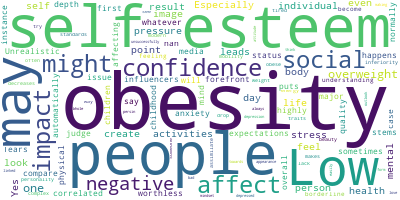

In [5]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(raw_data['If Yes or No, please explain why'].values.astype(str)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
# Defining the helper functions
def topNwords(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorTitle = count_vectorizer.fit_transform(text_data.values.astype(str))
    vectorTotal = np.sum(vectorTitle, axis=0)
    wordIndices = np.flip(np.argsort(vectorTotal)[0,:], 1)
    wordValues = np.flip(np.sort(vectorTotal)[0,:],1)
    
    wordVec = np.zeros((n_top_words, vectorTitle .shape[1]))
    for i in range(n_top_words):
        wordVec[i,wordIndices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(wordVec)]

    return (words, wordValues[0,:n_top_words].tolist()[0])
    
    
count_vectorizer = CountVectorizer(stop_words='english')
words, wordValues = topNwords(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

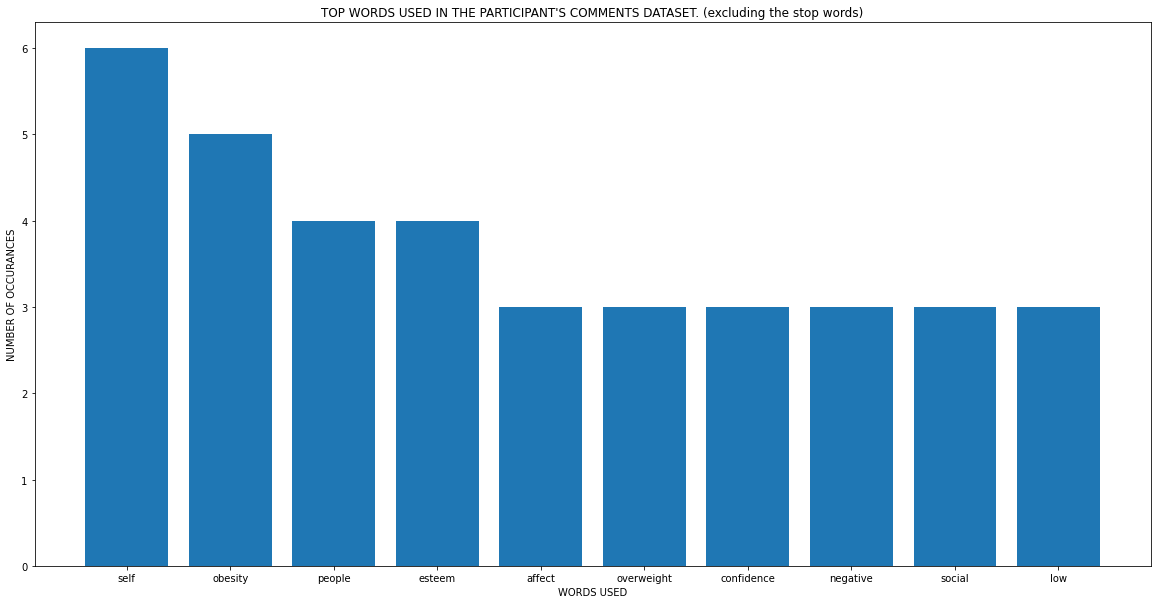

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), wordValues);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title("TOP WORDS USED IN THE PARTICIPANT'S COMMENTS DATASET. (excluding the stop words)");
ax.set_xlabel('WORDS USED');
ax.set_ylabel('NUMBER OF OCCURANCES');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=10)
#small_text_sample = datafText.sample(n=123, random_state=0).values
small_text_sample = reindexed_data.values.astype(str)
print('REVIEW BEFORE VECTORIZATION: {}'.format(small_text_sample[1]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('REVIEW AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[1]))

REVIEW BEFORE VECTORIZATION: How people look at you and judge you. Tears you down.
REVIEW AFTER VECTORIZATION: 
  (0, 7)	1


In [ ]:
numberOfTopics = 9

In [ ]:
#Latent Semantic Analysis

In [ ]:
lSAModel = TruncatedSVD(n_components=numberOfTopics)
lSATopicMatrix = lSAModel.fit_transform(small_document_term_matrix)

In [ ]:
def collectLSAtopics(LDAModel, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    featureNames = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(numberOfTopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        wordsIDs = lSAModel.components_[i].argsort()[:-20 - 1:-1]
        words = [ featureNames[key] for key in wordsIDs]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
collectLSAtopics(lSAModel, 30)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,self,overweight,obesity,people,affect,affect,social,self,negative
1,esteem,negative,social,social,confidence,esteem,negative,negative,people
2,low,people,people,low,people,social,confidence,people,low
3,obesity,social,affect,esteem,overweight,negative,affect,obesity,esteem
4,confidence,obesity,confidence,self,esteem,self,esteem,social,obesity
5,affect,affect,overweight,overweight,negative,overweight,self,affect,affect
6,social,confidence,negative,confidence,self,obesity,low,confidence,confidence
7,people,low,low,affect,obesity,people,overweight,overweight,social
8,overweight,esteem,esteem,negative,social,low,people,esteem,self
9,negative,self,self,obesity,low,confidence,obesity,low,overweight


In [ ]:
# Defining the helper functions
###########Edit################
def collectKeys(topicMatrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topicMatrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    

In [ ]:
LSAkeys = collectKeys(lSATopicMatrix )
LSAcategories, lsa_counts = keys_to_counts(LSAkeys)

In [ ]:
# Defining the helper functions
#########################Edit#############################
def collectTopnWords(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    indicesOfTop_Word = []
    for topic in range(numberOfTopics):
        tempVectorSum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                tempVectorSum += document_term_matrix[i]
        tempVectorSum = tempVectorSum.toarray(long_string)
        top_n_word_indices = np.flip(np.argsort(tempVectorSum)[0][-n:],0)
        indicesOfTop_Word.append(top_n_word_indices)   
    top_words = []
    for topic in indicesOfTop_Word:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:

top_n_words_lsa = collectTopnWords(15, LSAkeys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

ValueError: ignored

In [ ]:

top3Words = collectTopnWords(3, LSAkeys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top3Words[i] for i in LSAcategories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(LSAcategories, lsa_counts);
ax.set_xticks(LSAcategories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF Word/s OCCURED');
ax.set_title('LSA TOPIC COUNT');
#plt.bar(color=['red'])
plt.show()

ValueError: ignored

In [ ]:

tsneLSAmodel = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=3000, verbose=1, random_state=0, angle=0.75)
tsneLSAvectors = tsneLSAmodel.fit_transform(lSATopicMatrix )

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 21 samples in 0.000s...
[t-SNE] Computed neighbors for 21 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.610874
[t-SNE] KL divergence after 800 iterations: 0.409141


In [ ]:
# Defining the helper functions
def collectTheMeanTopicVectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    collectTheMeanTopicVectors = []
    for t in range(numberOfTopics):
        topicArticles = []
        for i in range(len(keys)):
            if keys[i] == t:
                topicArticles.append(two_dim_vectors[i])    
        
        topicArticles = np.vstack(topicArticles)
        meanTopicArticles = np.mean(topicArticles, axis=0)
        collectTheMeanTopicVectors.append(meanTopicArticles)
    return collectTheMeanTopicVectors

In [ ]:

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:numberOfTopics]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [ ]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(small_document_term_matrix);

In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=numberOfTopics, init='nndsvd');
#fit the model
nnfTMatrix = model.fit_transform(xtfidf_norm)
nnfTMatrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [7.62480573e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 3.79653341e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.44816863e-01, 0.00000000e+00, 2.89852030e-01,
        2.71943652e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.61669749e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.75600591e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

In [ ]:
def collectNMFTopics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    featureNames = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(numberOfTopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        wordsIDs = model.components_[i].argsort()[:-20 - 1:-1]
        words = [featureNames[key] for key in wordsIDs]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
collectNMFTopics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,people,obesity,affect,negative,social,self,overweight,confidence,low
1,social,low,esteem,social,obesity,esteem,social,self,esteem
2,overweight,affect,confidence,self,self,social,self,low,self
3,self,confidence,obesity,people,people,people,people,affect,social
4,obesity,social,social,overweight,overweight,overweight,obesity,social,people
5,negative,self,self,obesity,negative,obesity,negative,people,overweight
6,low,people,people,low,low,negative,low,overweight,obesity
7,esteem,overweight,overweight,esteem,esteem,low,esteem,obesity,negative
8,confidence,negative,negative,confidence,confidence,confidence,confidence,negative,confidence
9,affect,esteem,low,affect,affect,affect,affect,esteem,affect


In [ ]:
nnfKEYS = collectKeys(nnfTMatrix)
nnfCategories, nnfCOUNTS = keys_to_counts(nnfKEYS)

In [ ]:

nTopWords_nnf = collectTopnWords(15, nnfKEYS, small_document_term_matrix, small_count_vectorizer)

for i in range(len(nTopWords_nnf)):
    print("Topic {}: ".format(i+1), nTopWords_nnf[i])

ValueError: ignored

In [ ]:
top_3_words = collectTopnWords(3, nnfKEYS, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in nnfCategories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(nnfCategories, nnfCOUNTS);
ax.set_xticks(nnfCategories);
ax.set_xticklabels(labels);
ax.set_title('NNF TOPIC COUNT');
ax.set_ylabel('NUMBER OF WORDS(SPECIFIC) IN REVIEWS');

ValueError: ignored